In [1]:
import numpy as np
import datetime
import torch
import torchvision            
import torch.nn as nn
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

print(torch.__version__)

1.7.0+cu101


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import os
from os import path
import struct
from array import array
from PIL import Image
#import matplotlib

%matplotlib inline
from matplotlib.pyplot import imshow, imsave

In [3]:
MODEL_NAME = 'DNN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = DNN, DEVICE = cuda


In [4]:
# file needed: "kr-vs-kp.data", download link: https://archive.ics.uci.edu/ml/datasets/Chess+%28King-Rook+vs.+King-Pawn%29
# Import file on colab

# from google.colab import files
# uploaded = files.upload()

# OR place the data file on the current directory

In [48]:
attribute_names = ['bkblk','bknwy','bkon8','bkona','bkspr','bkxbq','bkxcr','bkxwp','blxwp','bxqsq','cntxt','dsopp','dwipd',
 'hdchk','katri','mulch','qxmsq','r2ar8','reskd','reskr','rimmx','rkxwp','rxmsq','simpl','skach','skewr',
 'skrxp','spcop','stlmt','thrsk','wkcti','wkna8','wknck','wkovl','wkpos','wtoeg']
attribute_features = []
X = []
y = []

def isAttrListed(attribute):
  for feature in attribute_features:
    if attribute == feature:
      return True
  return False

with open("kr-vs-kp.data", 'r') as f:
  lines = f.readlines()

for idx, line in enumerate(lines):
  attributes = line.strip('\n').split(',')
  result = attributes[-1]
  attributes = attributes[:-1]

  if result == 'won':
    y.append(1)
  elif result == 'nowin':
    y.append(0)
  
  for attr in attributes:
    if not isAttrListed(attr):
      attribute_features.append(attr)
    X.append(attribute_features.index(attr))

X_ = normalize(np.array(X).reshape((-1, 36)))
X = X_.reshape(-1, 1, 36)
y_ = y = np.array(y)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777)
X_tr, X_ts, y_tr, y_ts = train_test_split(X_, y_, test_size=0.3, random_state=777)

In [50]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
          
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = {'label': self.y[idx], 'data': self.X[idx]}

        return sample

In [51]:
train_data = MyDataset(X_train, y_train)
test_data = MyDataset(X_test, y_test)

In [52]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        
        self.conv = nn.Sequential(
            # (N, 1, 36)
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            # (N, 16, 18)
            nn.Conv1d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            # (N, 64, 9)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*9, 64),
            nn.BatchNorm1d(64, momentum=0.1),
            nn.Linear(64, 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        y_ = self.conv(x) # (N, 64. 9)
        y_ = y_.view(y_.size(0), -1) # (N, 64*9)
        y_ = self.fc(y_)
        return y_

In [53]:
model = MyCNN().to(DEVICE)
batch_size = 64
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=100, shuffle=False, drop_last=False)

# utility function to measure time

import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# set loss function and optimizer

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

# reset loss history
all_losses = []

In [54]:
max_epoch = 100        # maximum number of epochs
step = 0             # initialize step counter variable

plot_every = 200
total_loss = 0 # Reset every plot_every iters

start = time.time()

for epoch in range(max_epoch):
    for idx, datas in enumerate(train_loader):

        data = datas['data'] # (N, 1, 36)
        label = datas['label'] # (N, )

        # Training Discriminator
        x, y = data.to(DEVICE, dtype=torch.float), label.to(DEVICE, dtype=torch.float) # (N, 1, 28, 28), (N, )
        
        y_hat = model(x) # (N, 2)  # forward propagation
        
        loss = criterion(y_hat, y.long())  # computing loss
        total_loss += loss.item()
          
        optim.zero_grad()           # reset gradient
        loss.backward()             # back-propagation (compute gradient)
        optim.step()                # update parameters with gradient
        
        if (step + 1) % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
        
        step += 1

In [55]:
# # periodically evalute model on test data
model.eval()

acc = 0.
with torch.no_grad():   # disable autograd
    for idx, datas in enumerate(train_loader):

        labels = datas['label'] # (N, )
        images = datas['data'] # (N, 1, 28, 28)
        x, y = images.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float) # (N, 1, 28, 28), (N, )
        y_hat = model(x) # (N, 20)
        loss = criterion(y_hat, y.long())
        _, indices = torch.max(y_hat, dim=-1)     # find maxmum along the last axis (argmax of each row)
                                                  # ex) max_value, max_idx = torch.max(input, dim)
        acc += torch.sum(indices == y).item()     # count correctly classified samples
                                                  # torch.sum() returns Tensor. Tensor.item() converts it to a value
print('*'*20, 'Train', '*'*20)
print('Step: {}, Loss: {}, Accuracy: {} %'.format(step, loss.item(), acc/len(train_data)*100))
print('*'*46)

acc = 0.
with torch.no_grad():   # disable autograd
    for idx, datas in enumerate(test_loader):

        labels = datas['label'] # (N, )
        images = datas['data'] # (N, 1, 28, 28)
        x, y = images.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float) # (N, 1, 28, 28), (N, )
        y_hat = model(x) # (N, 20)
        loss = criterion(y_hat, y.long())
        _, indices = torch.max(y_hat, dim=-1)     # find maxmum along the last axis (argmax of each row)
                                                  # ex) max_value, max_idx = torch.max(input, dim)
        acc += torch.sum(indices == y).item()     # count correctly classified samples
                                                  # torch.sum() returns Tensor. Tensor.item() converts it to a value
print('*'*20, 'Test', '*'*20)
print('Step: {}, Loss: {}, Accuracy: {} %'.format(step, loss.item(), acc/len(test_data)*100))
print('*'*46)

******************** Train ********************
Step: 3400, Loss: 0.3260023295879364, Accuracy: 95.9767545820295 %
**********************************************
******************** Test ********************
Step: 3400, Loss: 0.34561437368392944, Accuracy: 96.76746611053181 %
**********************************************


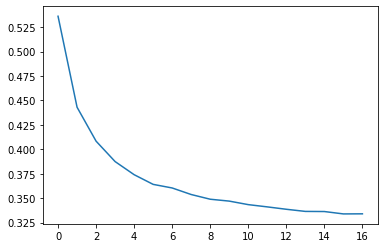

In [56]:
plt.figure()
plt.plot(all_losses)

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, log_loss)

# Step 1 - Separating training and testing datasets
print(':: Step 1 - Separating training and testing datasets')
print('Train data: ', X_tr.shape)
print('Test data: ', X_ts.shape)

# Steps 2 & 3 - Optimize hyperparameters via cross validation
print('\n:: Steps 2 & 3 - Optimize hyperparameters via cross validation')

# Instantiate a model object - # set the hyperparameters that you would like to fix here
svm = SVC()

# Set a serach range - # list out the hyperparameter values that you would like to test here
parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [0.001, 0.01, 0.1, 1, 10]}

# Find the best hyperparameters using GridSearchCV
gridsearch = GridSearchCV(svm, parameters, scoring='accuracy', cv=3)
gridsearch.fit(X_tr, y_tr)

# Show the best hyperparameters
# String starts with 'f' - print out a floating point number in the string
print(f'gridsearch.best_params_ = {gridsearch.best_params_}') 

# The best model is stored in 'best_svm'
best_svm = gridsearch.best_estimator_
print(best_svm)



# Step 4 - Model performance
print('\n:: Step 4 - Model performance')

y_pred = best_svm.predict(X_ts)
test_acc = accuracy_score(y_ts, y_pred)
print(f'test_acc = {test_acc}')



# Step 5 - Train final model on full dataset (optional)
print('\n:: Step 5 - Train final model on full dataset')
final_model = SVC(**gridsearch.best_params_)
final_model.fit(X_, y_)

:: Step 1 - Separating training and testing datasets
Train data:  (2237, 36)
Test data:  (959, 36)

:: Steps 2 & 3 - Optimize hyperparameters via cross validation
gridsearch.best_params_ = {'C': 1000, 'gamma': 0.1}
SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

:: Step 4 - Model performance
test_acc = 0.9895724713242962

:: Step 5 - Train final model on full dataset


SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)